# Regime-PCMCI: Detecting causal regimes from multivariate time series

Main reference: Elena Saggioro, Jana de Wiljes, Marlene Kretschmer, Jakob Runge; Reconstructing regime-dependent causal relationships from observational time series. Chaos 1 November 2020; 30 (11): 113115. https://doi.org/10.1063/5.0020538

The following Nature Review Earth and Environment paper provides an overview of causal inference for time series in general: https://github.com/jakobrunge/tigramite/blob/master/tutorials/Runge_Causal_Inference_for_Time_Series_NREE.pdf

In [2]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn
from sklearn.linear_model import LinearRegression


import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.rpcmci import RPCMCI


from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb

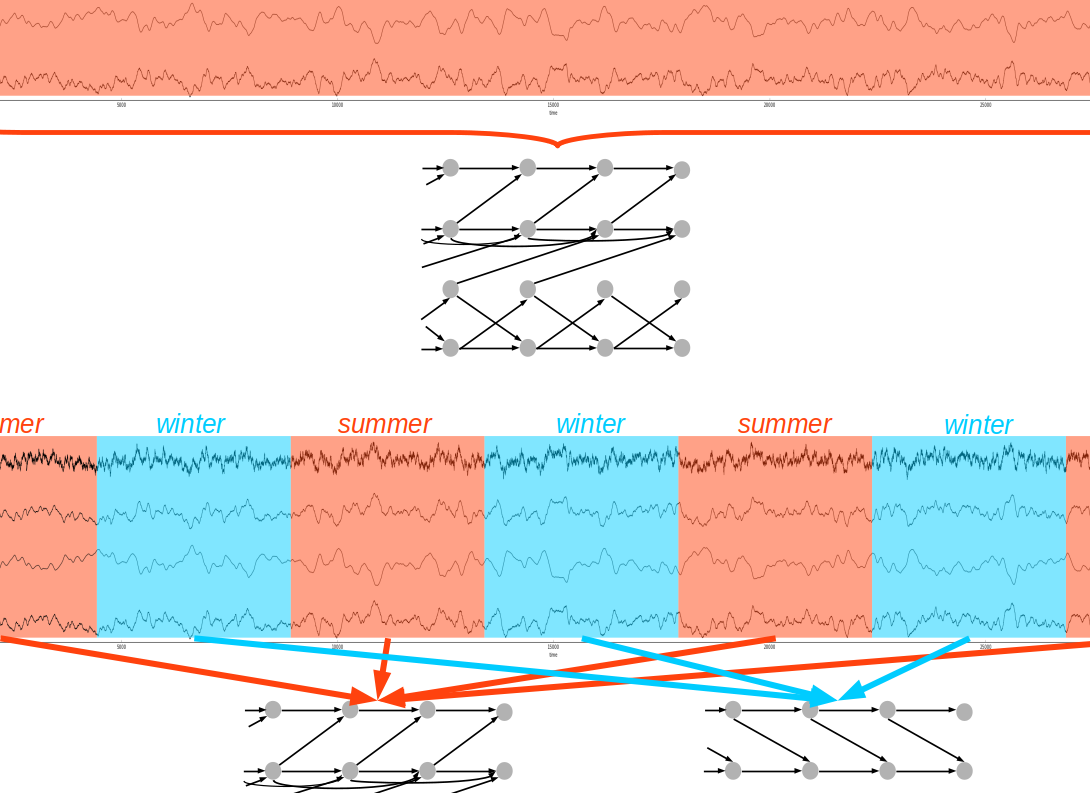

Below we generate data in which the underlying causal structure alternates between two regimes that are referred to as winter half year and summer half year. In particular, the two regimes differ in that one causal effect is of opposite sign in the two regimes.

Importantly, Regime-PCMCI does not require a periodic structure of regimes, they can be arbitrarily distributed across time. However, there are assumptions on the number of regimes and their persistency. For the assumptions of R-PCMCI, see the paper above.

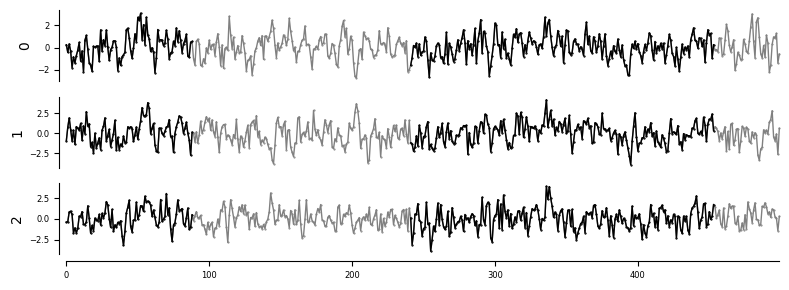

In [2]:
np.random.seed(43)
T = 500
var_names = [r'$X^1$', r'$X^2$', r'$X^3$']
data = np.random.randn(T, 3)
data_mask = np.zeros(data.shape)
for t in range(1, T):
    if (t % 365) < 3*30 or (t % 365) > 8*30: 
        # Winter half year
        data[t, 0] +=  0.4*data[t-1, 0]
        data[t, 1] +=  0.3*data[t-1, 1] + 0.7*data[t-1, 0]
        data[t, 2] +=  0.3*data[t-1, 2] + 0.7*data[t-1, 0]
    else:
        # Summer half year
        data_mask[[t, t-1]] = True
        data[t, 0] +=  0.4*data[t-1, 0]
        data[t, 1] +=  0.3*data[t-1, 1]  - 0.7*data[t-1, 0]
        data[t, 2] +=  0.3*data[t-1, 2] 

T, N = data.shape
# print data_mask[:100, 0]
datatime = np.arange(T)
dataframe_plotting = pp.DataFrame(data, mask=data_mask)
tp.plot_timeseries(dataframe_plotting, figsize=(8,3), grey_masked_samples='data'); plt.show()


### Generating synth data with ad-hoc regime generation

In [ ]:
from PCMCI_RNN.data_generator import RegimeDataGenerator

sign_12 = {
        'positive_sign': {
            'min_length': 70,
            'max_length': 100,
            'relationships': {
                1: {
                    0: {0: 0.2},
                    1: {1: 0.2, 0: 0.8}
                }
            }
        },
        'negative-sign': {
            'min_length': 70,
            'max_length': 100,
            'relationships': {
                1: {
                    0: {0: 0.2},
                    1: {1: 0.2, 0: -0.8}
                }
            }
        }
    }

T = 3000
generator = RegimeDataGenerator(
        regime_definitions=sign_12,
        n_vars=2,
        T=T,
        seed=43,
        noise_std=1.0,
        cycle_regimes=False,  # pick randomly, excluding last regime
    )

sign_12_data, assignments, number_of_switches= generator.generate_data()

print("Data shape:", data.shape)
print("Assignments shape:", assignments.shape)
print("Unique regimes:", np.unique(assignments, return_counts=True))
print("Number of switches between regimes:", number_of_switches)

positive_mask = generator.create_mask_for_regime(assignments, "positive_sign")
print("Mask shape:", positive_mask.shape)

Data shape: (500, 3)
Assignments shape: (3000,)
Unique regimes: (array(['negative-sign', 'positive_sign'], dtype='<U13'), array([1398, 1602]))
Number of switches between regimes: 34
Mask shape: (3000, 2)


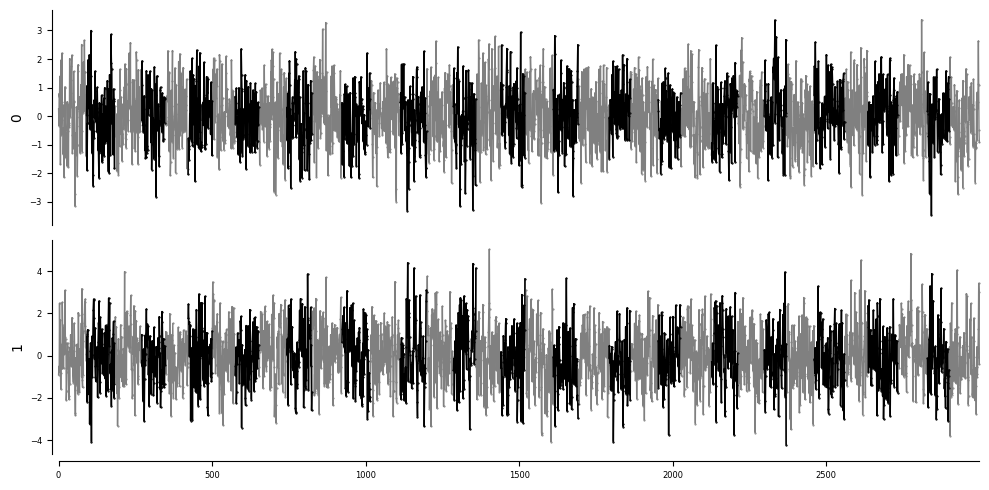

In [4]:
datatime = np.arange(T)  
dataframe_plotting = pp.DataFrame(sign_12_data, mask=positive_mask)
tp.plot_timeseries(dataframe_plotting, figsize=(10,5), grey_masked_samples='data'); plt.show()

## Learning graphs if causal regimes are known

Let's first reconstruct the causal graphs belonging to the two regimes by explicitly including knowledge about the regimes via *masking*. See the tutorial on masking in the folder dataset_challenges.

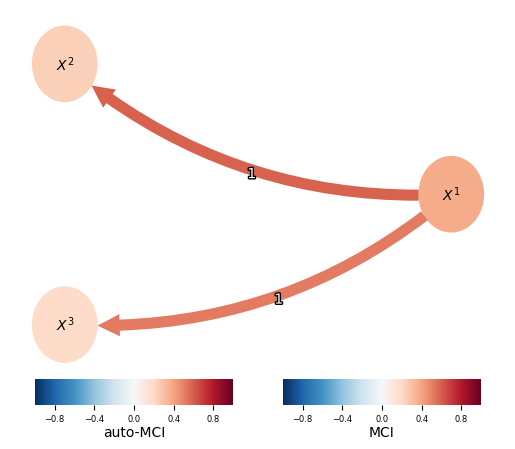

In [3]:
# First mask out the summer
pcmci = PCMCI(dataframe=dataframe_plotting, 
              cond_ind_test=ParCorr(mask_type='y'))
results = pcmci.run_pcmci(tau_min=1, tau_max=2, pc_alpha=0.2, alpha_level=0.01)
tp.plot_graph(val_matrix=results['val_matrix'],
              graph=results['graph'], var_names=var_names,
              node_aspect=0.5, node_size=0.5
)
plt.show()

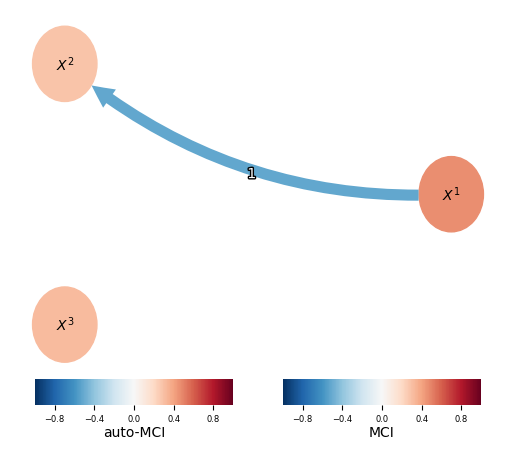

In [4]:
# Then mask out the winter
dataframe_plotting.mask[0] = dataframe_plotting.mask[0] == False
pcmci = PCMCI(dataframe=dataframe_plotting, 
              cond_ind_test=ParCorr(mask_type='y'))
results = pcmci.run_pcmci(tau_min=1, tau_max=2, pc_alpha=0.2, alpha_level=0.01)
tp.plot_graph(val_matrix=results['val_matrix'],
              graph=results['graph'], var_names=var_names,
              node_aspect=0.5, node_size=0.5
)
plt.show()

## Ignore regimes and learn graph over all data

Just as an illustration.

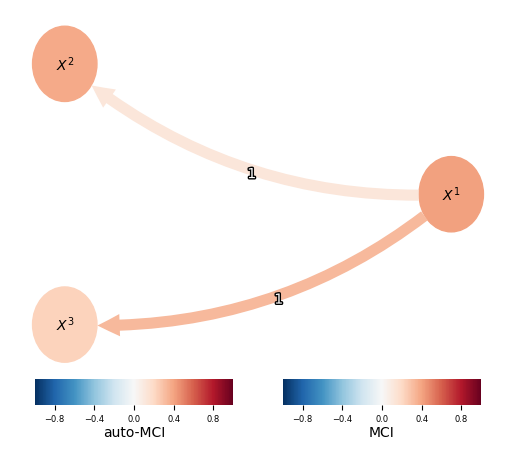

In [5]:
pcmci = PCMCI(dataframe=pp.DataFrame(data), 
              cond_ind_test=ParCorr())
results = pcmci.run_pcmci(tau_min=1, tau_max=2, pc_alpha=0.2, alpha_level=0.01)
tp.plot_graph(val_matrix=results['val_matrix'],
              graph=results['graph'], var_names=var_names,
              node_aspect=0.5, node_size=0.5
)
plt.show()

## Learn regimes and corresponding causal graphs

Now run RPCMCI to automatically detect the causal regimes without assuming them with masking.

In [6]:
# Dataframe init. Note that for R-PCMCI no data mask can be used. 
# The mask will internally be overwritten to learn regimes
dataframe = pp.DataFrame(data)

# Init RPCMCI with the dataframe, a conditional independence test for use in PCMCI, 
# and a prediction_model which is used to predict each variable given its learned parents. This prediction 
# is then used inside the regime learning optimization step.
rpcmci = RPCMCI(dataframe=dataframe, 
                cond_ind_test=ParCorr(),
                prediction_model=LinearRegression(),
                verbosity=1)

# RPCMCI parameters, see paper
num_regimes = 2
max_transitions = 4
switch_thres = 0.05
num_iterations = 20
max_anneal = 10
tau_min = 1
tau_max = 1
pc_alpha = 0.2
alpha_level = 0.01
n_jobs = -1     # uses joblib for parallelization, here all available cpus are used

# Run RPCMCI
results = rpcmci.run_rpcmci(
    num_regimes=num_regimes, max_transitions=max_transitions, 
    switch_thres=switch_thres, 
    num_iterations=num_iterations, max_anneal=max_anneal, 

    tau_min=tau_min, tau_max=tau_max,
    pc_alpha=pc_alpha, alpha_level=alpha_level, 
    n_jobs=n_jobs
    )

if results is None:
    print("All annealings resulted in errors. Increase annealing and tune other parameters!")
else:
    print("Done!")


################# Annealing iteration a = 0 ####################


###### Optimization step q = 0
################ Regime k = 0

################# Annealing iteration a = 1 ####################


###### Optimization step q = 0
################ Regime k = 0
################ Regime k = 1

################# Annealing iteration a = 2 ####################


###### Optimization step q = 0
################ Regime k = 0
################ Regime k = 1
################ Regime k = 1

################# Annealing iteration a = 3 ####################


###### Optimization step q = 0
################ Regime k = 0
################ Regime k = 1

Optimal objective: reached.
Difference in abs value between the previous and current gamma (shape num_regimesxT) : 503.5399195755775

###### Optimization step q = 1
################ Regime k = 0
################ Regime k = 1

Optimal objective: reached.
Difference in abs value between the previous and current gamma (shape num_regimesxT) : 490.9369752339443

###

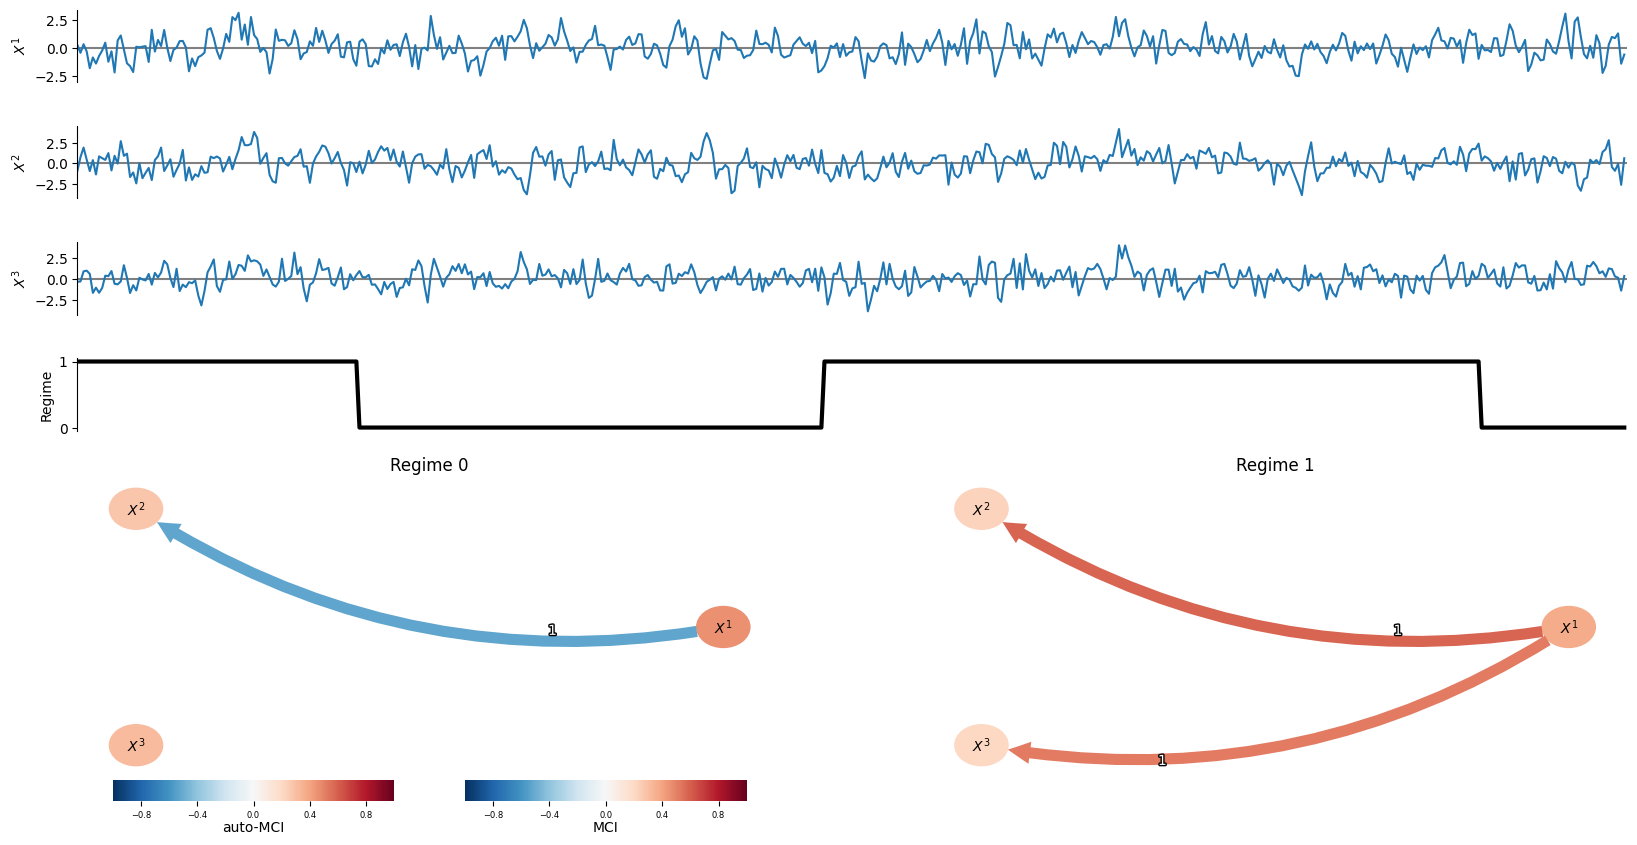

In [7]:
regimes = results['regimes'].argmax(axis=0)
n_regimes = len(results['causal_results'])

# Create nice Mosaic plot
mosaic = [['data %s' %j for i in range(n_regimes)] for j in range(N+1)]
for n in range(N):
    mosaic.append(['graph %s' %i for i in range(n_regimes)])

fig, axs = plt.subplot_mosaic(mosaic = mosaic, figsize=(20, 10))

for j in range(N):
    ax = axs['data %s' %j]
    ax.axhline(0., color='grey')
    ax.plot(datatime, data[:,j])
    for loc, spine in ax.spines.items():
        if loc != 'left':
            spine.set_color("none")
    
    ax.xaxis.set_ticks([])   
    ax.set_xlim(0., T)
    ax.set_ylabel(var_names[j])
    
# Regime variable
ax = axs['data %s' %N]
ax.plot(datatime, regimes.astype('int'), lw=3, color='black')
for loc, spine in ax.spines.items():
    if loc != 'left':
        spine.set_color("none")
ax.xaxis.set_ticks([]) 
ax.yaxis.set_ticks(range(n_regimes))   
ax.set_xlim(0., T)
ax.set_ylabel("Regime")
    
# Causal graphs for each regime
for w in range(n_regimes):
    if w == 0: show_colorbar=True
    else: show_colorbar = False
    tp.plot_graph(graph=results['causal_results'][w]['graph'], 
                  val_matrix=results['causal_results'][w]['val_matrix'], 
                  show_colorbar=show_colorbar,
                  var_names=var_names,
                  fig_ax=(fig, axs['graph %s' %w]))
    axs['graph %s' %w].set_title("Regime %d" %w, pad=-4)

fig.subplots_adjust(hspace=0.6)
plt.show()

The regimes are reconstructed well here. For any real data application, we suggest to construct some toy data with similar properties and then explore which parameters work best for RPCMCI. 

We also would like to note that, at present, we have no theoretical results on which types of regime changes are identifiable with this method. However, we demonstrate in numerical experiments, that it works for changes in the graph structure, or the magnitude and sign of links.

### Sign12 case

In [5]:
# Dataframe init. Note that for R-PCMCI no data mask can be used. 
# The mask will internally be overwritten to learn regimes
dataframe = pp.DataFrame(sign_12_data)

# Init RPCMCI with the dataframe, a conditional independence test for use in PCMCI, 
# and a prediction_model which is used to predict each variable given its learned parents. This prediction 
# is then used inside the regime learning optimization step.
rpcmci = RPCMCI(dataframe=dataframe, 
                cond_ind_test=ParCorr(),
                prediction_model=LinearRegression(),
                verbosity=1)

# RPCMCI parameters, see paper
num_regimes = 2
max_transitions = number_of_switches
switch_thres = 0.05
num_iterations = 20
max_anneal = 10
tau_min = 1
tau_max = 1
pc_alpha = 0.2
alpha_level = 0.01
n_jobs = -1     # uses joblib for parallelization, here all available cpus are used

# Run RPCMCI
results = rpcmci.run_rpcmci(
    num_regimes=num_regimes, max_transitions=max_transitions, 
    switch_thres=switch_thres, 
    num_iterations=num_iterations, max_anneal=max_anneal, 

    tau_min=tau_min, tau_max=tau_max,
    pc_alpha=pc_alpha, alpha_level=alpha_level, 
    n_jobs=n_jobs
    )

if results is None:
    print("All annealings resulted in errors. Increase annealing and tune other parameters!")
else:
    print("Done!")


################# Annealing iteration a = 0 ####################


###### Optimization step q = 0
################ Regime k = 0
################ Regime k = 1

################# Annealing iteration a = 4 ####################


###### Optimization step q = 0
################ Regime k = 0

################# Annealing iteration a = 2 ####################


###### Optimization step q = 0
################ Regime k = 0
################ Regime k = 1
################ Regime k = 1

################# Annealing iteration a = 5 ####################


###### Optimization step q = 0
################ Regime k = 0
################ Regime k = 1

################# Annealing iteration a = 1 ####################


###### Optimization step q = 0
################ Regime k = 0

################# Annealing iteration a = 6 ####################


###### Optimization step q = 0
################ Regime k = 0
################ Regime k = 1
################ Regime k = 1

################# Annealing iteration a = 3 #

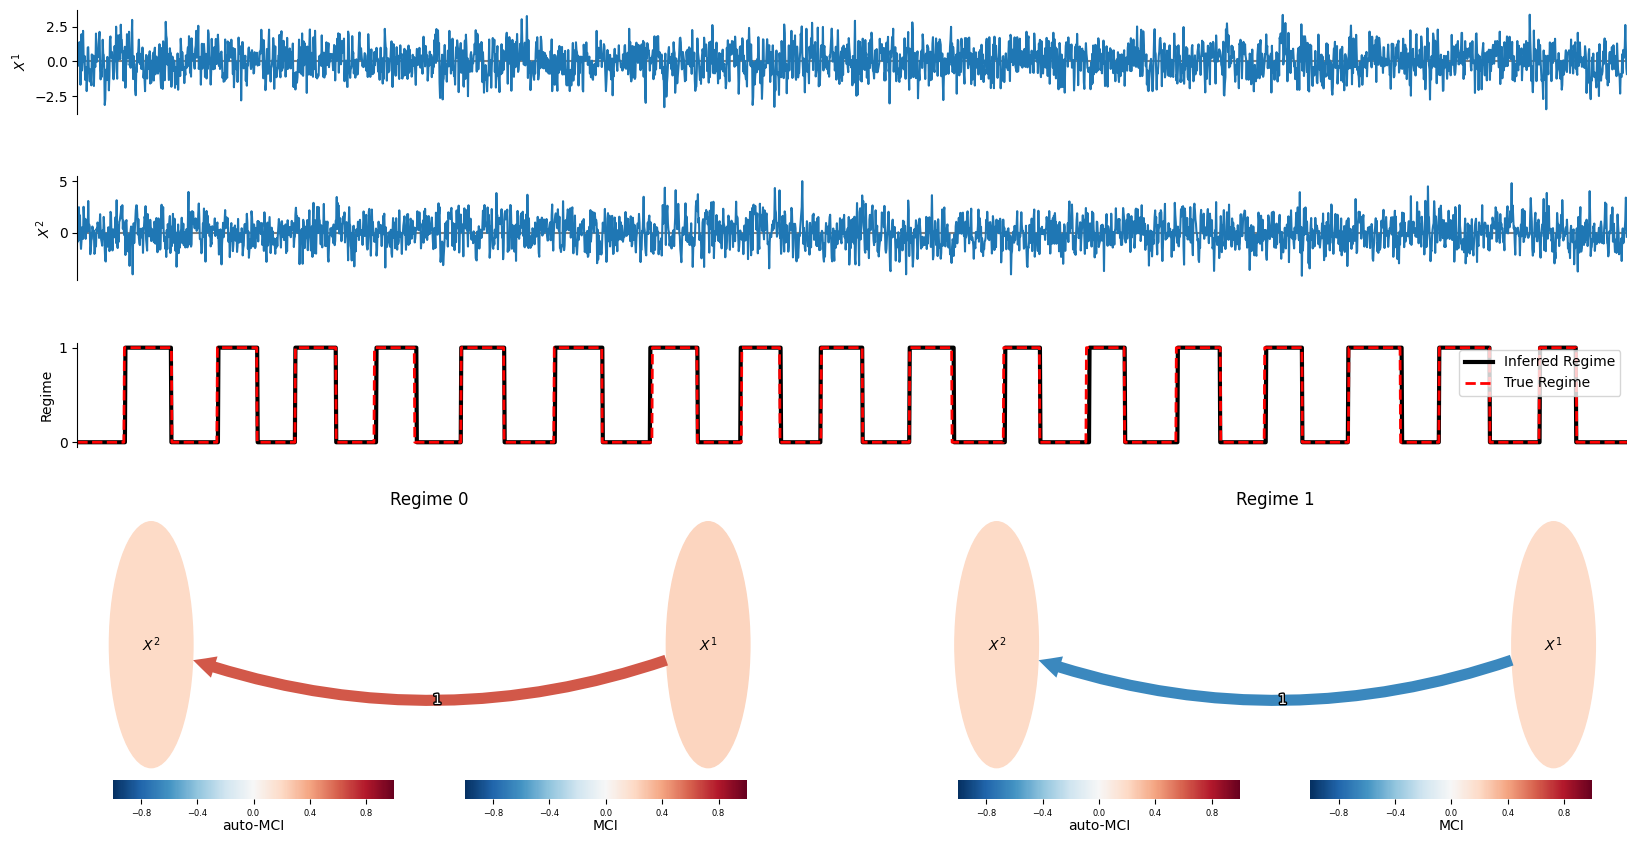

In [102]:
unique_regimes = np.unique(assignments)               # e.g. ['Summer','Winter']
regime_map = {reg: i for i, reg in enumerate(unique_regimes)}
true_regimes_int = np.array([regime_map[r] for r in assignments])

inverted_regimes = np.ones(len(true_regimes_int),dtype=np.int64) - true_regimes_int

var_names = [r'$X^1$', r'$X^2$']
N = 2

regimes = results['regimes'].argmax(axis=0)
n_regimes = len(results['causal_results'])

# Create nice Mosaic plot
mosaic = [['data %s' %j for i in range(n_regimes)] for j in range(N+1)]
for n in range(N):
    mosaic.append(['graph %s' %i for i in range(n_regimes)])

fig, axs = plt.subplot_mosaic(mosaic = mosaic, figsize=(20, 10))

for j in range(N):
    ax = axs['data %s' %j]
    ax.axhline(0., color='grey')
    ax.plot(datatime, sign_12_data[:,j])
    for loc, spine in ax.spines.items():
        if loc != 'left':
            spine.set_color("none")
    
    ax.xaxis.set_ticks([])   
    ax.set_xlim(0., T)
    ax.set_ylabel(var_names[j])
    
# Regime variable
ax = axs['data %s' %N]
# Plot the inferred regime in black
ax.plot(datatime, regimes.astype(int), lw=3, color='black', label='Inferred Regime')

# Plot the true regime in, say, red
ax.plot(datatime, inverted_regimes, lw=2, color='red',linestyle='--', alpha=1, label='True Regime')

# Tidy up
ax.set_xlim(0., T)
#ax.axhline(0., color='grey')
for loc, spine in ax.spines.items():
    if loc != 'left':
        spine.set_color("none")
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks(range(n_regimes))
ax.set_ylabel("Regime")

# Finally, add a legend
ax.legend()
# Causal graphs for each regime
for w in range(n_regimes):
    show_colorbar = True
    tp.plot_graph(graph=results['causal_results'][w]['graph'], 
                  val_matrix=results['causal_results'][w]['val_matrix'], 
                  show_colorbar=show_colorbar,
                  var_names=var_names,
                  node_aspect=1,
                  fig_ax=(fig, axs['graph %s' %w]))
    axs['graph %s' %w].set_title("Regime %d" %w, pad=-4)

fig.subplots_adjust(hspace=0.6)
plt.show()

In [101]:
# save results to file
import pickle
import os

from datetime import datetime

experiment_name = "sign_12"

timestamp = datetime.now().strftime("%d-%m-%y_%H-%M")

results_path = os.path.join("results", f"{experiment_name}_{timestamp}.pkl")


with open(results_path, "wb") as f:
    pickle.dump(results, f)

# load results from file
with open(results_path, "rb") as f:
    loaded_results = pickle.load(f)



Percentage of wrong regime assignments:

In [41]:
wrong_assignments = np.sum(np.abs(inverted_regimes - regimes.astype(int)))
percentage_wrong = 100*wrong_assignments / len(inverted_regimes)

In [43]:
percentage_wrong

1.8666666666666667

Strenght of links:

In [45]:
results['causal_results'][0]['val_matrix'][:,:,1]

array([[0.2246261 , 0.6244026 ],
       [0.01853714, 0.19972167]])

In [49]:
results['causal_results'][0]['graph'][:,:,1]

array([['-->', '-->'],
       ['', '-->']], dtype='<U3')

In [48]:
results['causal_results'][1]['val_matrix'][:,:,1]

array([[ 0.18886778, -0.6429322 ],
       [ 0.00398702,  0.19723075]])

In [50]:
results['causal_results'][1]['graph'][:,:,1]

array([['-->', '-->'],
       ['', '-->']], dtype='<U3')

Estimating causal effects

In [71]:
# Estimating causal effect
from tigramite.causal_effects import CausalEffects
c_effects = CausalEffects(results['causal_results'][0]['graph'], X=[(0,-1)], Y=[(1,0)], graph_type='stationary_dag')

In [64]:
# create data mask from inferred regimes
inferred_data_mask = np.zeros((T, N))

inferred_data_mask[regimes.astype(bool)] = True


In [65]:
masked_sign_12_data = pp.DataFrame(sign_12_data, mask=inferred_data_mask)

In [74]:
effects = c_effects.fit_total_effect(
        dataframe=masked_sign_12_data, 
        estimator=LinearRegression(),
        adjustment_set='optimal',
        conditional_estimator=None,  
        data_transform=None,
        mask_type='y',
        verbosity=1

        )

TypeError: CausalEffects.fit_total_effect() got an unexpected keyword argument 'verbosity'

In [85]:
effects.model.__dict__

{'mask_type': 'y',
 'dataframe': <tigramite.data_processing.DataFrame at 0x2986d2bc0>,
 'N': 2,
 'T': {0: 3000},
 'model': LinearRegression(),
 'conditional_model': LinearRegression(),
 'data_transform': None,
 'verbosity': 0,
 'all_parents': None,
 'selected_variables': None,
 'tau_max': 2,
 'fit_results': {'observation_array': array([[-0.32702312,  0.79266872,  0.65672233, ...,  2.63251663,
           1.10716204, -0.47802479],
         [-0.77676687,  2.48898085,  0.58395918, ...,  3.42598181,
           3.00721568, -0.40680447],
         [-0.51069195, -0.77676687,  2.48898085, ...,  1.27097895,
           3.42598181,  3.00721568]]),
  'xyz': array([0, 1, 3]),
  'model': LinearRegression(),
  'fitted_data_transform': None},
 'X': [(0, -1)],
 'Y': [(1, 0)],
 'conditions': [],
 'Z': [(1, -1)],
 'lenX': 1,
 'lenS': 0,
 'cut_off': 'tau_max',
 'fitted_data_transform': None}

In [93]:
import numpy as np
from sklearn.linear_model import LinearRegression

class LinearLinkFitter:
    """
    Fits a linear model for each variable i, using all parents j at each lag l
    indicated in a 3D graph. Returns a (N, N, L) coefficient array with np.nan 
    for non-links.
    """
    def __init__(self, data, graph_3d):
        """
        Args:
            data: shape (T, N) time-series. data[t, i] = X_{i,t}.
            graph_3d: shape (N, N, L). e.g. graph[i, j, l] = '-->' if j->i at lag l,
                      or '' if no link.
        """
        self.data = data
        self.graph = graph_3d
        
        self.T, self.N = data.shape
        # The third dimension is the maximum lag
        self.L = graph_3d.shape[2]

        # Just a quick check
        if graph_3d.shape[0] != self.N or graph_3d.shape[1] != self.N:
            raise ValueError("graph_3d's first two dims must match data's N.")

    def fit_links(self):
        """
        Fits one linear model per variable i, using all indicated parents j,l.
        Returns:
            coefs: shape (N, N, L) array of floats, with np.nan where no link is present.
        """
        coefs = np.full((self.N, self.N, self.L), np.nan, dtype=float)

        # For each child variable i:
        for i in range(self.N):
            # 1) Find all (j, l) such that graph[i,j,l] is a non-empty link
            parent_lags = []
            for j in range(self.N):
                for l in range(self.L):
                    if self.graph[ j,i, l] != '':
                        parent_lags.append((j, l))

            if not parent_lags:
                # no parents => skip
                continue

            # 2) Build design matrix X and target y
            # We want to predict data[t, i] from data[t-l, j] for (j,l) in parent_lags.
            max_lag = max(l for _, l in parent_lags)
            # We can only form Y[t] for t >= max_lag
            T_eff = self.T - max_lag  # number of valid rows

            # Initialize design matrix:
            # shape = (T_eff, num_parents), plus we will feed it into scikit-learn
            X_mat = np.zeros((T_eff, len(parent_lags)), dtype=float)
            y_vec = np.zeros(T_eff, dtype=float)

            for row_idx, t in enumerate(range(max_lag, self.T)):
                # y = X_{i, t}
                y_vec[row_idx] = self.data[t, i]
                # fill columns
                for col_idx, (j, l) in enumerate(parent_lags):
                    X_mat[row_idx, col_idx] = self.data[t - l, j]

            # 3) Fit linear regression
            lr = LinearRegression(fit_intercept=True)
            lr.fit(X_mat, y_vec)
            betas = lr.coef_  # shape = (num_parents,)

            # 4) Store the fitted betas in coefs[i, j, l]
            for (col_idx, (j, l)) in enumerate(parent_lags):
                coefs[j, i, l] = betas[col_idx]

        return coefs


In [94]:
fitter = LinearLinkFitter(sign_12_data[regimes.astype(bool)], results['causal_results'][1]['graph'])
coefs = fitter.fit_links()

# coefs is shape (2,2,2) with fitted regression weights
# (some may be NaN if no link is indicated)
print("Coefficient array shape:", coefs.shape)

Coefficient array shape: (2, 2, 2)
Coefficients:
 [[[        nan  0.20165231]
  [        nan -0.83676689]]

 [[        nan         nan]
  [        nan  0.20671495]]]


In [95]:
coefs[:,:,1]

array([[ 0.20165231, -0.83676689],
       [        nan,  0.20671495]])

In [96]:
coefs[:,:,0]

array([[nan, nan],
       [nan, nan]])

In [97]:
fitter = LinearLinkFitter(sign_12_data[~regimes.astype(bool)], results['causal_results'][1]['graph'])
coefs = fitter.fit_links()

# coefs is shape (2,2,2) with fitted regression weights
# (some may be NaN if no link is indicated)
print("Coefficient array shape:", coefs.shape)
print("Coefficients:\n", coefs)

Coefficient array shape: (2, 2, 2)
Coefficients:
 [[[       nan 0.22382562]
  [       nan 0.75212994]]

 [[       nan        nan]
  [       nan 0.20221996]]]


In [98]:
coefs[:,:,1]

array([[0.22382562, 0.75212994],
       [       nan, 0.20221996]])

In [14]:
# compute percentage of error in the coefficients

true_coefs= np.array([[[0.2, 0.8], [0, 0.2]],[[0.2, -0.8], [0, 0.2]]])

estimated_coefs = np.array([[[0.2238, 0.752], [0, 0.202]],[[0.201, -0.83], [0, 0.206]]])

np.sum(np.abs(true_coefs - estimated_coefs)) / np.sum(np.abs(true_coefs))



0.04616666666666664

### Arrow direction case

In [1]:
from PCMCI_RNN.linear_fitter import LinearLinkFitter

In [3]:
from PCMCI_RNN.data_generator import RegimeDataGenerator

arrow_direction = {
        '12-link': {
            'min_length': 70,
            'max_length': 100,
            'relationships': {
                1: {
                    0: {0: 0.2},
                    1: {1: 0.2, 0: 0.8}
                }
            }
        },
        '21-link': {
            'min_length': 70,
            'max_length': 100,
            'relationships': {
                1: {
                    0: {1: 0.8, 0: 0.2},
                    1: {1: 0.2}
                }
            }
        }
    }

T = 3000




    


In [6]:
generator = RegimeDataGenerator(
        regime_definitions=arrow_direction,
        n_vars=2,
        T=T,
        seed=43,
        noise_std=1.0,
        cycle_regimes=False,  # pick randomly, excluding last regime
    )

arrow_direction_data, assignments, number_of_switches= generator.generate_data()

print("Data shape:", arrow_direction_data.shape)
print("Assignments shape:", assignments.shape)
print("Unique regimes:", np.unique(assignments, return_counts=True))
print("Number of switches between regimes:", number_of_switches)

positive_mask = generator.create_mask_for_regime(assignments, "positive_sign")
print("Mask shape:", positive_mask.shape)

Data shape: (3000, 2)
Assignments shape: (3000,)
Unique regimes: (array(['12-link', '21-link'], dtype='<U7'), array([1398, 1602]))
Number of switches between regimes: 34
Mask shape: (3000, 2)


In [7]:
# Dataframe init. Note that for R-PCMCI no data mask can be used. 
# The mask will internally be overwritten to learn regimes
dataframe = pp.DataFrame(arrow_direction_data)

# Init RPCMCI with the dataframe, a conditional independence test for use in PCMCI, 
# and a prediction_model which is used to predict each variable given its learned parents. This prediction 
# is then used inside the regime learning optimization step.
rpcmci = RPCMCI(dataframe=dataframe, 
                cond_ind_test=ParCorr(),
                prediction_model=LinearRegression(),
                verbosity=1)

# RPCMCI parameters, see paper
num_regimes = 2
max_transitions = number_of_switches
switch_thres = 0.05
num_iterations = 20
max_anneal = 10
tau_min = 1
tau_max = 1
pc_alpha = 0.2
alpha_level = 0.01
n_jobs = -1     # uses joblib for parallelization, here all available cpus are used

# Run RPCMCI
results = rpcmci.run_rpcmci(
    num_regimes=num_regimes, max_transitions=max_transitions, 
    switch_thres=switch_thres, 
    num_iterations=num_iterations, max_anneal=max_anneal, 

    tau_min=tau_min, tau_max=tau_max,
    pc_alpha=pc_alpha, alpha_level=alpha_level, 
    n_jobs=n_jobs
    )

if results is None:
    print("All annealings resulted in errors. Increase annealing and tune other parameters!")
else:
    print("Done!")


################# Annealing iteration a = 4 ####################


###### Optimization step q = 0
################ Regime k = 0
################ Regime k = 1

################# Annealing iteration a = 5 ####################


###### Optimization step q = 0
################ Regime k = 0

################# Annealing iteration a = 0 ####################


###### Optimization step q = 0
################ Regime k = 0

################# Annealing iteration a = 7 ####################


###### Optimization step q = 0
################ Regime k = 0

################# Annealing iteration a = 3 ####################


###### Optimization step q = 0
################ Regime k = 0

################# Annealing iteration a = 2 ####################


###### Optimization step q = 0
################ Regime k = 0
################ Regime k = 1

################# Annealing iteration a = 1 ####################


###### Optimization step q = 0
################ Regime k = 0

################# Annealing iteratio

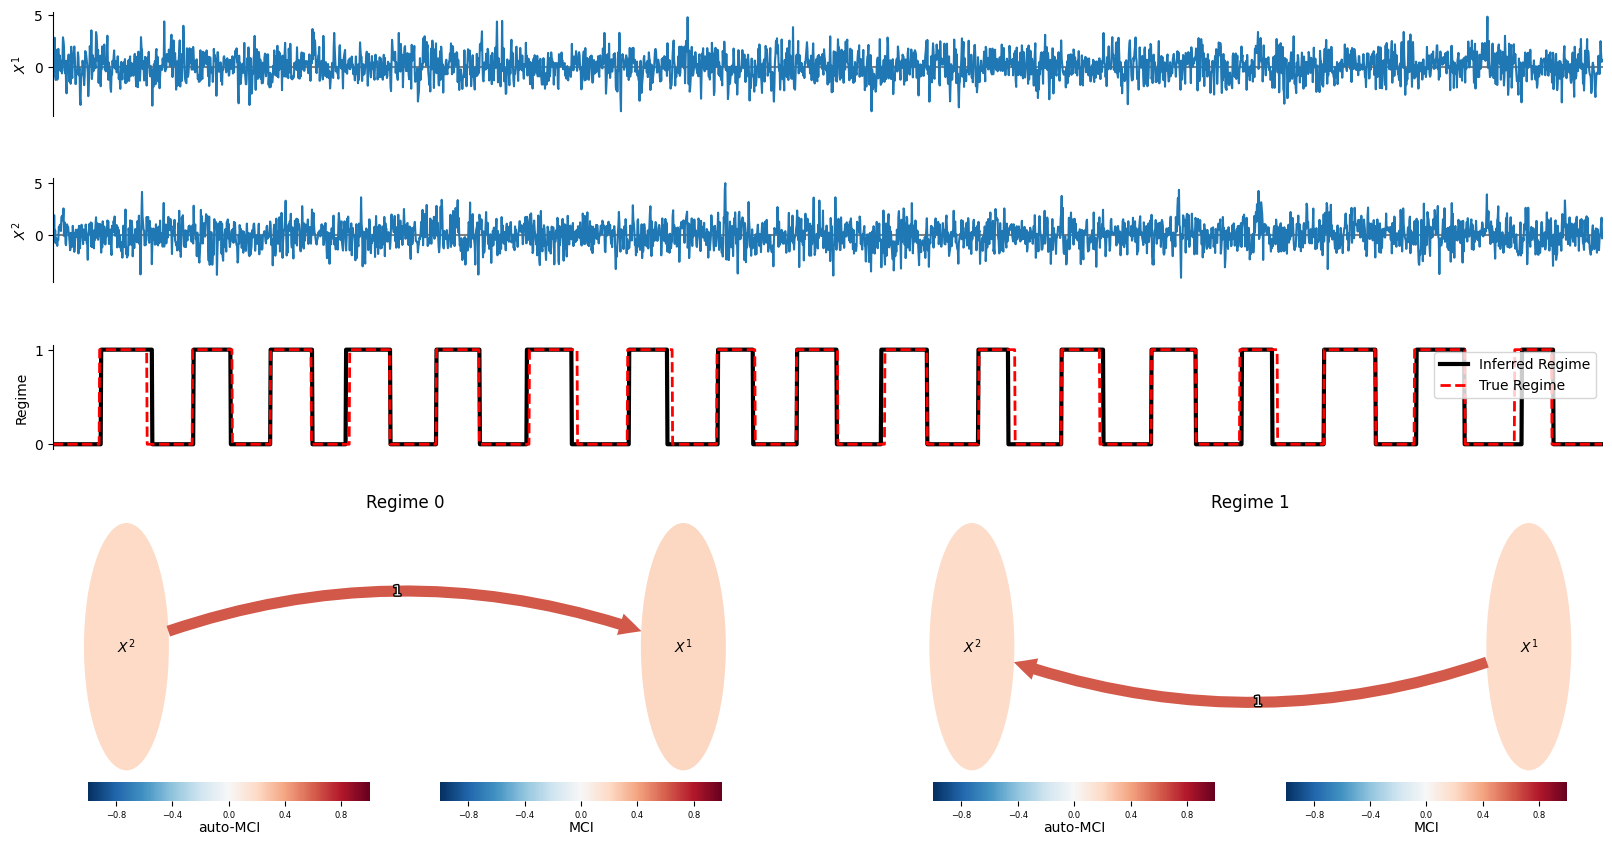

In [10]:
unique_regimes = np.unique(assignments)               # e.g. ['Summer','Winter']
regime_map = {reg: i for i, reg in enumerate(unique_regimes)}
true_regimes_int = np.array([regime_map[r] for r in assignments])
datatime = np.arange(T)  
inverted_regimes = np.ones(len(true_regimes_int),dtype=np.int64) - true_regimes_int

var_names = [r'$X^1$', r'$X^2$']
N = 2

regimes = results['regimes'].argmax(axis=0)
n_regimes = len(results['causal_results'])

# Create nice Mosaic plot
mosaic = [['data %s' %j for i in range(n_regimes)] for j in range(N+1)]
for n in range(N):
    mosaic.append(['graph %s' %i for i in range(n_regimes)])

fig, axs = plt.subplot_mosaic(mosaic = mosaic, figsize=(20, 10))

for j in range(N):
    ax = axs['data %s' %j]
    ax.axhline(0., color='grey')
    ax.plot(datatime, arrow_direction_data[:,j])
    for loc, spine in ax.spines.items():
        if loc != 'left':
            spine.set_color("none")
    
    ax.xaxis.set_ticks([])   
    ax.set_xlim(0., T)
    ax.set_ylabel(var_names[j])
    
# Regime variable
ax = axs['data %s' %N]
# Plot the inferred regime in black
ax.plot(datatime, regimes.astype(int), lw=3, color='black', label='Inferred Regime')

# Plot the true regime in, say, red
ax.plot(datatime, inverted_regimes, lw=2, color='red',linestyle='--', alpha=1, label='True Regime')

# Tidy up
ax.set_xlim(0., T)
#ax.axhline(0., color='grey')
for loc, spine in ax.spines.items():
    if loc != 'left':
        spine.set_color("none")
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks(range(n_regimes))
ax.set_ylabel("Regime")

# Finally, add a legend
ax.legend()
# Causal graphs for each regime
for w in range(n_regimes):
    show_colorbar = True
    tp.plot_graph(graph=results['causal_results'][w]['graph'], 
                  val_matrix=results['causal_results'][w]['val_matrix'], 
                  show_colorbar=show_colorbar,
                  var_names=var_names,
                  node_aspect=1,
                  fig_ax=(fig, axs['graph %s' %w]))
    axs['graph %s' %w].set_title("Regime %d" %w, pad=-4)

fig.subplots_adjust(hspace=0.6)
plt.show()

In [29]:
fitter = LinearLinkFitter(arrow_direction_data[regimes.astype(bool)], results['causal_results'][1]['graph'])
normal_regime_coefs = fitter.fit_links()

# coefs is shape (2,2,2) with fitted regression weights
# (some may be NaN if no link is indicated)
print("Coefficient array shape:", normal_regime_coefs.shape)

Coefficient array shape: (2, 2, 2)


In [27]:
normal_regime_coefs[:,:,1]

array([[0.19224799, 0.79194655],
       [       nan, 0.17457394]])

In [30]:
fitter = LinearLinkFitter(arrow_direction_data[~regimes.astype(bool)], results['causal_results'][0]['graph'])
inverse_regime_coefs = fitter.fit_links()

# coefs is shape (2,2,2) with fitted regression weights
# (some may be NaN if no link is indicated)
print("Coefficient array shape:", inverse_regime_coefs.shape)

Coefficient array shape: (2, 2, 2)


In [31]:
inverse_regime_coefs[:,:,1]

array([[0.2012878 ,        nan],
       [0.79455648, 0.2181068 ]])

In [60]:
# compute percentage of error in the coefficients

true_coefs= np.array([[[0.2, 0.8], [0, 0.2]],[[0.2, 0], [0.8, 0.2]]])

# concatenate the coefficients
estimated_coefs = np.stack((normal_regime_coefs[:,:,1], inverse_regime_coefs[:,:,1]), axis=0)

# replace nan with 0
estimated_coefs = np.nan_to_num(estimated_coefs)
np.sum(np.abs(true_coefs - estimated_coefs)) / np.sum(np.abs(true_coefs))

0.027529013719194036